In [1]:
import jax
import jax.numpy as jnp
import flax.linen as nn
from flax.training import train_state
import optax
import numpy as np
import matplotlib.pyplot as plt
print(jax.devices())
# Import the data loader from your existing utils
from data_utils import get_base_data_jax, DATASET_CONFIGS

[CudaDevice(id=0), CudaDevice(id=1), CudaDevice(id=2), CudaDevice(id=3)]


In [2]:
# ==========================================
# 1. Define the CNN Architecture
# ==========================================
class SimpleCNN(nn.Module):
    """A minimal CNN that is easy to expand or modify."""
    num_classes: int

    @nn.compact
    def __call__(self, x):
        # Convolutional Block 1
        x = nn.Conv(features=16, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(3, 3))
        
        # block 2
        x = nn.Conv(features=16, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(3, 3))
        
        # Convolutional Block 3
        x = nn.Conv(features=32, kernel_size=(3, 3))(x)
        x = nn.relu(x)
        x = nn.max_pool(x, window_shape=(3, 3), strides=(3, 3))
        
        # Flatten and Dense Layers
        # x = x.reshape((x.shape[0], -1))  # Flatten the spatial dimensions
        x = jnp.mean(x, axis=(1, 2)) # global average pooling
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)
        return x

class simpleMLP(nn.Module):
    num_classes: int
    
    @nn.compact
    def __call__(self, x):
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=128)(x)
        x = nn.relu(x)
        x = nn.Dense(features=self.num_classes)(x)
        return x

In [3]:
# ==========================================
# 2. Training Utilities
# ==========================================
def create_train_state(rng, learning_rate, input_shape, num_classes):
    """Initializes the model and the optimizer."""
    # model = SimpleCNN(num_classes=num_classes)
    model = simpleMLP(num_classes=num_classes)
    variables = model.init(rng, jnp.ones(input_shape))
    tx = optax.adam(learning_rate)
    print(jax.tree_util.tree_map(lambda x: f"{x.shape}\n", variables))
    return train_state.TrainState.create(
        apply_fn=model.apply, params=variables['params'], tx=tx
    )

@jax.jit
def train_step(state, batch_X, batch_Y):
    """Executes a single training step."""
    def loss_fn(params):
        logits = state.apply_fn({'params': params}, batch_X)
        loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_Y).mean()
        return loss, logits

    grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
    (loss, logits), grads = grad_fn(state.params)
    state = state.apply_gradients(grads=grads)
    
    # Calculate accuracy
    preds = jnp.argmax(logits, axis=-1)
    acc = jnp.mean(preds == batch_Y)
    return state, loss, acc

In [4]:
@jax.jit
def eval_step(state, batch_X, batch_Y):
    """Executes a single evaluation step."""
    logits = state.apply_fn({'params': state.params}, batch_X)
    loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=batch_Y).mean()
    preds = jnp.argmax(logits, axis=-1)
    acc = jnp.mean(preds == batch_Y)
    return loss, acc

def get_batches(X, Y, batch_size):
    """Simple generator to yield batches of data."""
    num_samples = len(X)
    indices = np.random.permutation(num_samples)
    for i in range(0, num_samples, batch_size):
        batch_idx = indices[i:i + batch_size]
        yield X[batch_idx], Y[batch_idx]

In [5]:
# ==========================================
# 3. Main Execution (Binary Classification with Balanced Classes)
# ==========================================

# --- Config ---
batch_size = 128
epochs = 100
learning_rate = 1e-3
seed = 42

# Since CIFAR-100 has 500 train and 100 test images per class, 
# we restrict all datasets to this exact number to ensure fair comparison.
TRAIN_PER_CLASS = 500
TEST_PER_CLASS = 100

def balance_classes(X, Y, num_per_class, num_classes):
    """Extracts exactly `num_per_class` samples for each class."""
    X_balanced, Y_balanced = [], []
    for c in range(num_classes):
        # Find all indices for class c
        idx = jnp.where(Y == c)[0]
        # Take exactly num_per_class samples
        idx = idx[:num_per_class] 
        
        X_balanced.append(X[idx])
        Y_balanced.append(Y[idx])
        
    # Combine and shuffle
    X_out = jnp.concatenate(X_balanced, axis=0)
    Y_out = jnp.concatenate(Y_balanced, axis=0)
    
    # Shuffle to mix the classes
    perm = np.random.permutation(len(X_out))
    return X_out[perm], Y_out[perm]


# Dictionary to store loss histories for plotting
history = {}

# --- Train on all datasets ---
for dataset_name, config in DATASET_CONFIGS.items():
    print(f"\n========================================")
    print(f"Starting {dataset_name.upper()} (Balanced Binary)")
    print(f"========================================")
    
    num_classes_orig = 10
    
    # ---------------------------------------------------------
    # NEW: Pass img_size=28 to force CIFAR-100 to downsample.
    # Data utils will also automatically Grayscale CIFAR-100.
    # ---------------------------------------------------------
    X_train_flat, Y_train_orig = get_base_data_jax(dataset_name, root='./data/imagenet_28_gray', train=True)
    X_test_flat, Y_test_orig = get_base_data_jax(dataset_name, root='./data/imagenet_28_gray', train=False)

    # ---------------------------------------------------------
    # NEW: Restrict to exactly equal images per class (500 train, 100 test)
    # ---------------------------------------------------------
    X_train_flat, Y_train_orig = balance_classes(X_train_flat, Y_train_orig, TRAIN_PER_CLASS, num_classes_orig)
    X_test_flat, Y_test_orig = balance_classes(X_test_flat, Y_test_orig, TEST_PER_CLASS, num_classes_orig)

    # ---------------------------------------------------------
    # Binarize Labels: First half -> 0, Second half -> 1
    # ---------------------------------------------------------
    threshold = num_classes_orig // 2
    Y_train = jnp.where(Y_train_orig < threshold, 0, 1)
    Y_test = jnp.where(Y_test_orig < threshold, 0, 1)
    
    # Update the number of classes for the model
    num_classes = 2 

    # Unflatten to Image Shape (N, H, W, C). Since img_size=28, side is always 28.
    # num_samples, flat_dim = X_train_flat.shape
    # side = int(np.sqrt(flat_dim)) # Will be 28
    
    # X_train = X_train_flat.reshape(num_samples, side, side, 1)
    # X_test = X_test_flat.reshape(X_test_flat.shape[0], side, side, 1)
    
    # input_shape = (1, side, side, 1)

    # print(f"Train shape: {X_train.shape} | Test shape: {X_test.shape}")
    input_shape = 784

    # Initialize Model
    rng = jax.random.PRNGKey(seed)
    rng, init_rng = jax.random.split(rng)
    state = create_train_state(init_rng, learning_rate, input_shape, num_classes)

    # Trackers for this dataset
    train_losses, eval_losses = [], []
    train_accs, test_accs = [], []

    # Training Loop
    for epoch in range(epochs):
        train_loss, train_acc = 0.0, 0.0
        num_batches = 0
        
        # Train
        for batch_X, batch_Y in get_batches(X_train_flat, Y_train, batch_size):
            state, loss, acc = train_step(state, batch_X, batch_Y)
            train_loss += loss
            train_acc += acc
            num_batches += 1
            
        train_loss /= num_batches
        train_acc /= num_batches
        
        # Evaluate
        eval_loss, eval_acc = eval_step(state, X_test_flat, Y_test)
        
        # Record metrics
        train_losses.append(float(train_loss))
        eval_losses.append(float(eval_loss))
        train_accs.append(float(train_acc))
        test_accs.append(float(eval_acc))

        print(f"Epoch {epoch + 1}/{epochs} | "
            f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
            f"Test Loss: {eval_loss:.4f}, Acc: {eval_acc:.4f}")

    # Store history for the dataset
    history[dataset_name] = {
        'train': train_accs,
        'eval': test_accs
    }


Starting IMAGENET_28_GRAY (Balanced Binary)
Loading imagenet_28_gray (Split=train) directly from .npy into JAX arrays...
Loading imagenet_28_gray (Split=test) directly from .npy into JAX arrays...
{'params': {'Dense_0': {'bias': '(128,)\n', 'kernel': '(784, 128)\n'}, 'Dense_1': {'bias': '(128,)\n', 'kernel': '(128, 128)\n'}, 'Dense_2': {'bias': '(128,)\n', 'kernel': '(128, 128)\n'}, 'Dense_3': {'bias': '(128,)\n', 'kernel': '(128, 128)\n'}, 'Dense_4': {'bias': '(2,)\n', 'kernel': '(128, 2)\n'}}}
Epoch 1/100 | Train Loss: 0.6618, Acc: 0.6090 | Test Loss: 0.6392, Acc: 0.6240
Epoch 2/100 | Train Loss: 0.6385, Acc: 0.6371 | Test Loss: 0.6227, Acc: 0.6770
Epoch 3/100 | Train Loss: 0.6316, Acc: 0.6490 | Test Loss: 0.6663, Acc: 0.6160
Epoch 4/100 | Train Loss: 0.6486, Acc: 0.6258 | Test Loss: 0.6308, Acc: 0.6610
Epoch 5/100 | Train Loss: 0.6238, Acc: 0.6529 | Test Loss: 0.6176, Acc: 0.6600
Epoch 6/100 | Train Loss: 0.6224, Acc: 0.6572 | Test Loss: 0.6267, Acc: 0.6640
Epoch 7/100 | Train Loss


Generating loss curves...


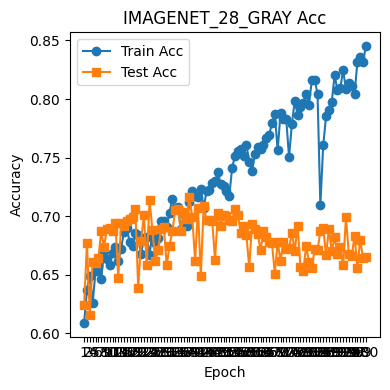

In [6]:

# ==========================================
# 4. Plot Loss Curves
# ==========================================
print("\nGenerating loss curves...")
num_datasets = len(history)
fig, axes = plt.subplots(1, num_datasets, figsize=(4 * num_datasets, 4))

# Handle case if there's only 1 dataset in the config
if num_datasets == 1:
    axes = [axes]
    
for ax, (ds_name, metrics) in zip(axes, history.items()):
    epochs_range = range(1, epochs + 1)
    ax.plot(epochs_range, metrics['train'], label='Train Acc', marker='o')
    ax.plot(epochs_range, metrics['eval'], label='Test Acc', marker='s')
    
    ax.set_title(f"{ds_name.upper()} Acc")
    ax.set_xlabel("Epoch")
    ax.set_ylabel("Accuracy")
    ax.legend()
    # ax.grid(True, linestyle='--', alpha=0.7)
    ax.set_xticks(epochs_range)
    
plt.tight_layout()
# plot_filename = "dataset_loss_curves.png"
# plt.savefig(plot_filename, dpi=150)
# plt.close()
plt.show()
# print(f"Finished! Saved all loss curves to '{plot_filename}'.")